<a href="https://colab.research.google.com/github/OlegKret/LP_Hydropower_Reklaitis/blob/main/ver2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pulp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 20.4 MB/s eta 0:00:00


Status: Optimal
Optimal Value of Objective Function = -346376.2521598373
Generator_Power_(0,_0) = 500.0
Generator_Power_(0,_1) = 500.0
Generator_Power_(0,_10) = 500.0
Generator_Power_(0,_11) = 500.0
Generator_Power_(0,_12) = 500.0
Generator_Power_(0,_13) = 500.0
Generator_Power_(0,_14) = 500.0
Generator_Power_(0,_15) = 500.0
Generator_Power_(0,_16) = 500.0
Generator_Power_(0,_17) = 500.0
Generator_Power_(0,_18) = 500.0
Generator_Power_(0,_19) = 500.0
Generator_Power_(0,_2) = 500.0
Generator_Power_(0,_20) = 500.0
Generator_Power_(0,_21) = 500.0
Generator_Power_(0,_22) = 500.0
Generator_Power_(0,_23) = 500.0
Generator_Power_(0,_3) = 500.0
Generator_Power_(0,_4) = 500.0
Generator_Power_(0,_5) = 500.0
Generator_Power_(0,_6) = 500.0
Generator_Power_(0,_7) = 500.0
Generator_Power_(0,_8) = 500.0
Generator_Power_(0,_9) = 500.0
Generator_Power_(1,_0) = 0.0
Generator_Power_(1,_1) = 10.0
Generator_Power_(1,_10) = 100.0
Generator_Power_(1,_11) = 110.0
Generator_Power_(1,_12) = 120.0
Generator_Powe

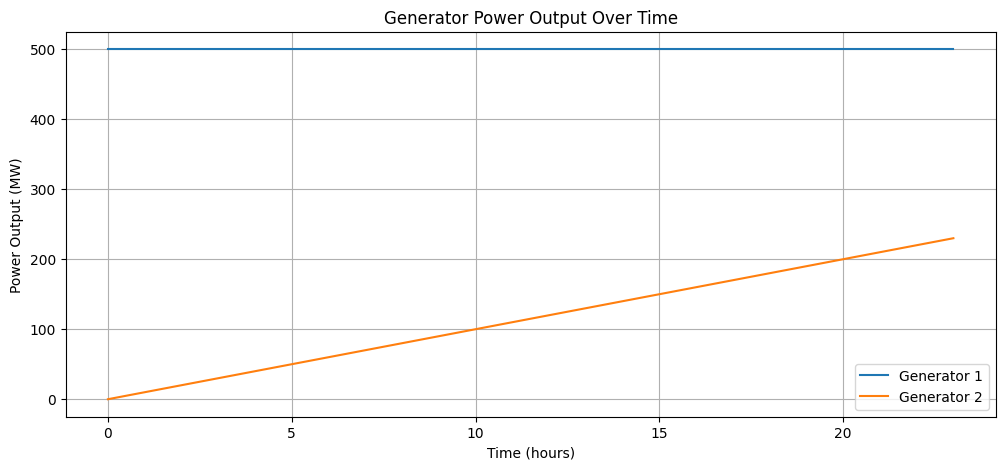

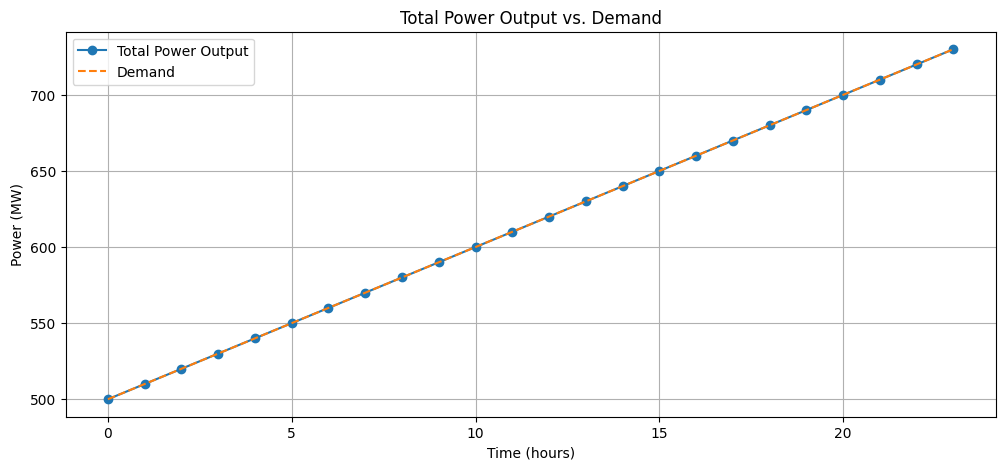

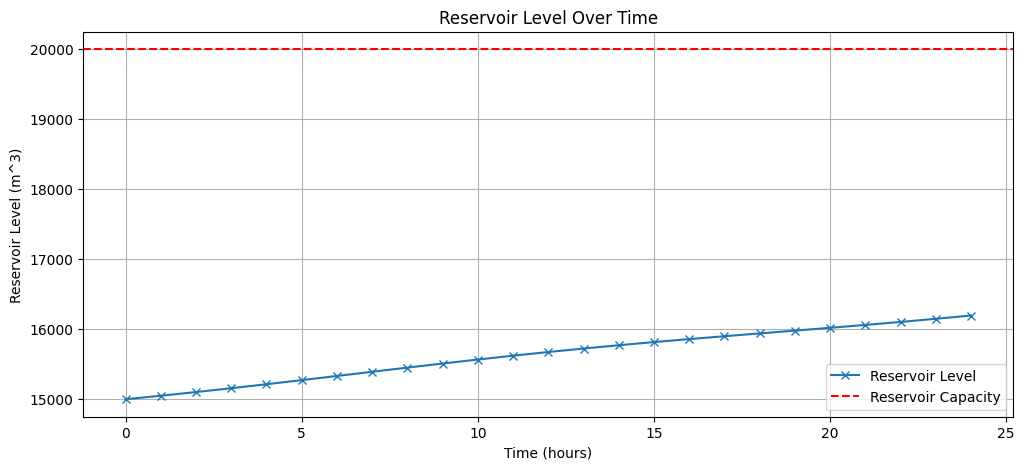

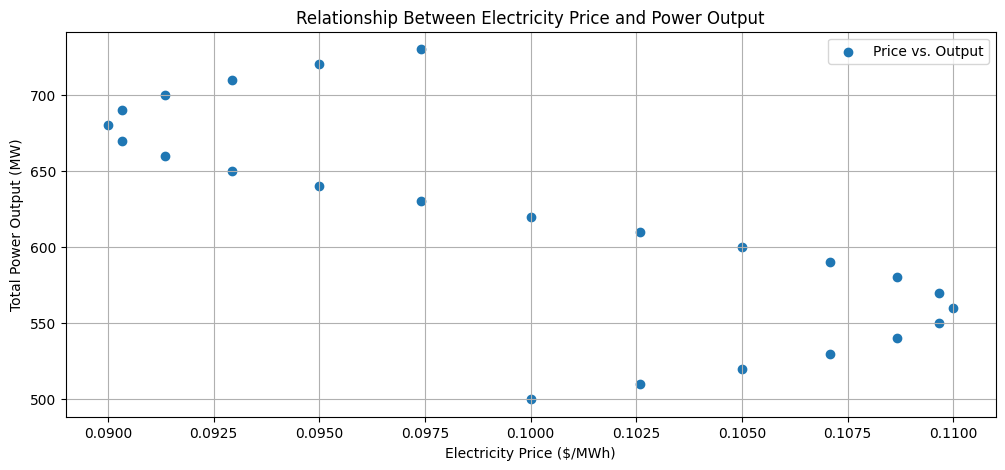

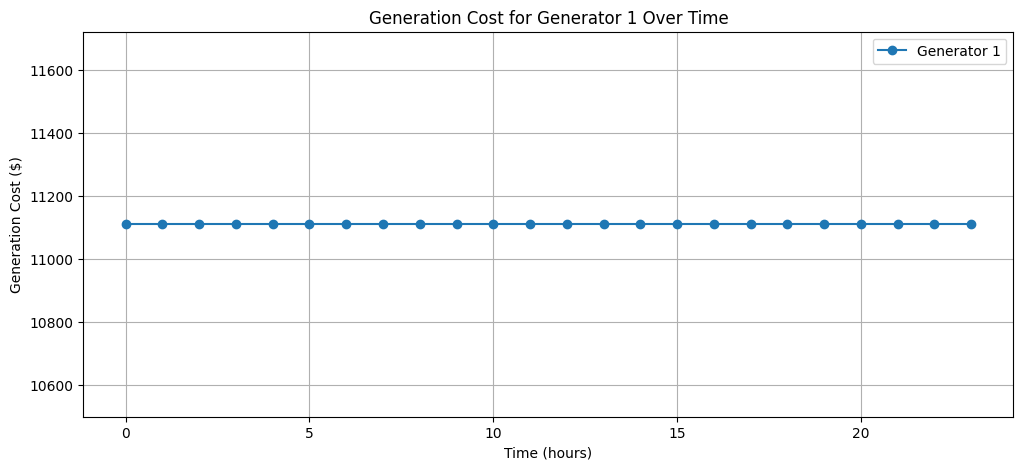

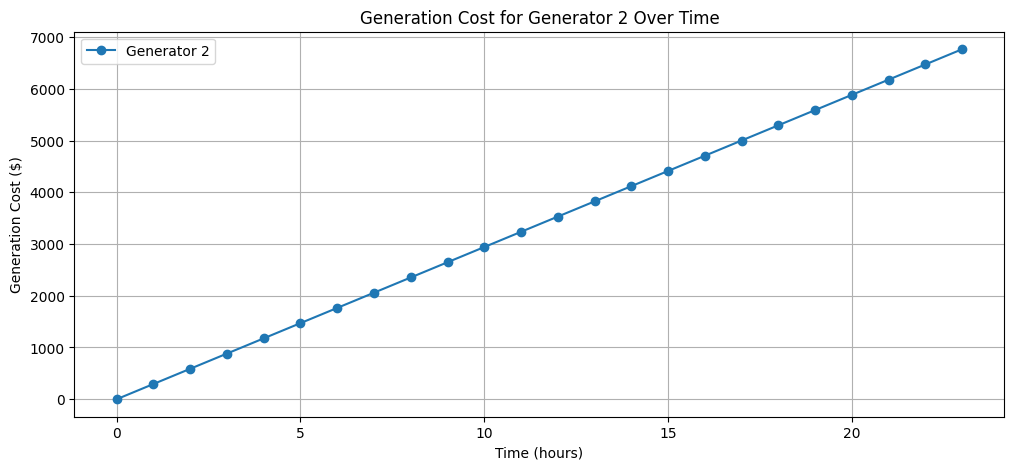

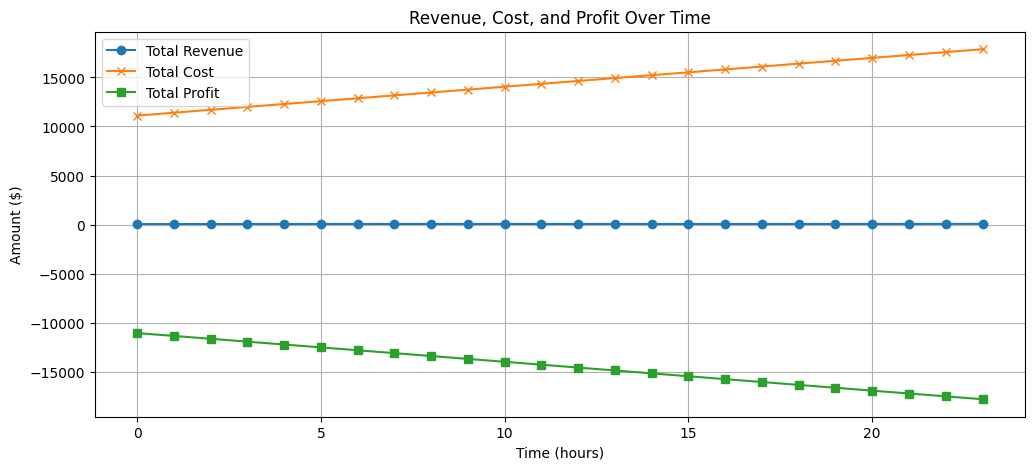

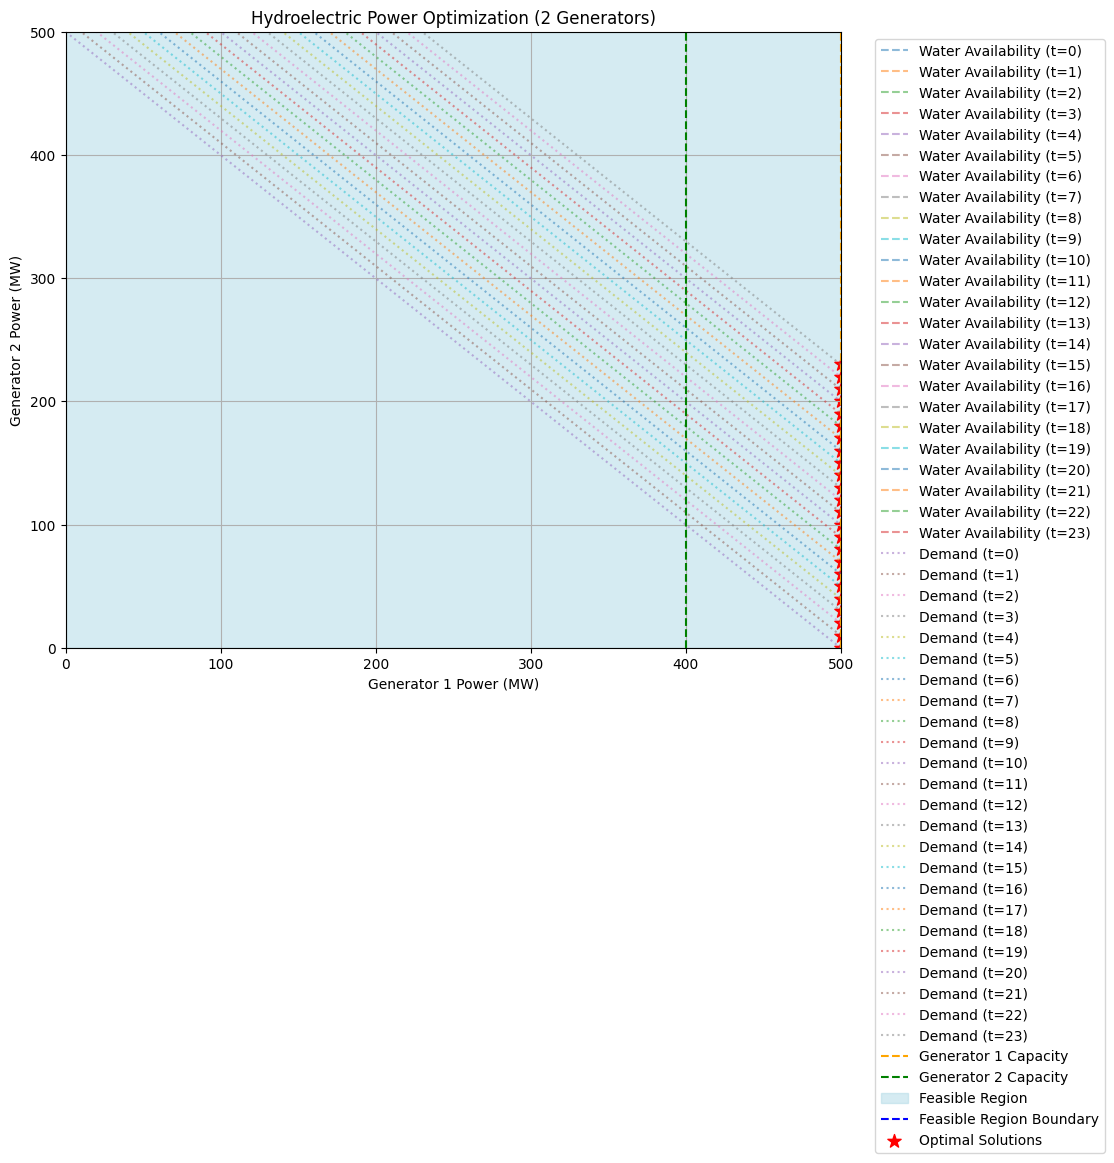

In [15]:
import pulp
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Model Parameters (you'll need to fill in actual data)
T = 24  # Number of time steps (hours)
num_generators = 2

# Generator data
water_usage_per_mw = [0.8, 1.2]  # m^3/s per MW for each generator
max_power = [500, 400]            # MW
generator_cost_per_mwh = [20, 25]  # $/MWh
generator_efficiency = [0.9, 0.85]
generator_min_power = [0, 0]   # Minimum power output (MW)

# Reservoir Parameters
reservoir_capacity = 20000       # Maximum reservoir capacity (m^3)
initial_reservoir_level = 15000  # Initial water level in the reservoir (m^3)
water_inflow = [50 + 10 * np.sin(2 * np.pi * t / 24) for t in range(T)]  # Varying water inflow (m^3/s)

# Market Parameters
electricity_prices = [0.1 + 0.01 * np.sin(2 * np.pi * t / 24) for t in range(T)] # Varying electricity price ($/MWh)
demand = [500 + 10 * t for t in range(T)]  # Demand for electricity (MW)

# Create the optimization problem
prob = pulp.LpProblem("Hydroelectric_Optimization_Reklaitis_BigM", pulp.LpMaximize)

# Big M Value
BIG_M = 1e6  # A sufficiently large value

# Decision Variables
power_output = pulp.LpVariable.dicts("Generator_Power",
                                      [(i, t) for i in range(num_generators) for t in range(T)],
                                      lowBound=0)
reservoir_level = pulp.LpVariable.dicts("Reservoir_Level", range(T+1), lowBound=0)
slack_variables = pulp.LpVariable.dicts("Slack_Vars", range(T), lowBound=0)  # New slack variables

# Objective Function (Maximize Profit, with penalty for slack variables)
prob += pulp.lpSum(electricity_prices[t] * pulp.lpSum(power_output[(i, t)] for i in range(num_generators))
                  - pulp.lpSum(generator_cost_per_mwh[i] * power_output[(i, t)] / generator_efficiency[i] for i in range(num_generators))
                  - BIG_M * slack_variables[t]   # Penalty for demand not met
                  for t in range(T))

# Constraints

# Initial reservoir level
prob += reservoir_level[0] == initial_reservoir_level

# Reservoir dynamics (water balance)
for t in range(T):
    water_usage = pulp.lpSum(
        power_output[(i, t)] * water_usage_per_mw[i] / (3600 * generator_efficiency[i])
        for i in range(num_generators))
    prob += reservoir_level[t + 1] == reservoir_level[t] + water_inflow[t] - water_usage

# Reservoir capacity constraint
for t in range(T+1):
    prob += reservoir_level[t] <= reservoir_capacity

# Power generation constraints (including minimum power)
for i in range(num_generators):
    for t in range(T):
        prob += power_output[(i, t)] <= max_power[i]
        prob += power_output[(i, t)] >= generator_min_power[i]

# Demand satisfaction constraints (modified with Big M method)
for t in range(T):
    prob += pulp.lpSum(power_output[(i, t)] for i in range(num_generators)) + slack_variables[t] >= demand[t]

# Solve the problem
prob.solve()
print("Status:", pulp.LpStatus[prob.status])
print(f"Optimal Value of Objective Function = {pulp.value(prob.objective)}")


# Display Results
for v in prob.variables():
    print(f"{v.name} = {v.varValue}")
print(f"Optimal Value of Objective Function = {pulp.value(prob.objective)}")


# ... 2D and 3D Visualizations as before

# Print status and optimal values
print("\nSolution Status:", pulp.LpStatus[prob.status])
for v in prob.variables():
    if v.varValue != 0:
        print(f"{v.name} = {v.varValue}")
print(f"Optimal Value of Objective Function = {pulp.value(prob.objective)}")

# ----- Enhanced Visualizations -----

# 1. Power Output for Each Generator over Time
plt.figure(figsize=(12, 5))
for i in range(num_generators):
    power_output_values = [power_output[(i, t)].varValue for t in range(T)]
    plt.plot(range(T), power_output_values, label=f'Generator {i+1}')
plt.xlabel('Time (hours)')
plt.ylabel('Power Output (MW)')
plt.title('Generator Power Output Over Time')
plt.legend()
plt.grid(True)
plt.show()

# 2. Total Power Output and Demand Over Time (Corrected)
total_power_output = [sum(power_output[(i, t)].varValue for i in range(num_generators)) for t in range(T)]
plt.figure(figsize=(12, 5))
plt.plot(range(T), total_power_output, label='Total Power Output', marker='o')
plt.plot(range(T), demand, label='Demand', linestyle='dashed')
plt.xlabel('Time (hours)')
plt.ylabel('Power (MW)')
plt.title('Total Power Output vs. Demand')
plt.legend()
plt.grid(True)
plt.show()

# 3. Reservoir Level Over Time
reservoir_levels = [reservoir_level[t].varValue for t in range(T + 1)]
plt.figure(figsize=(12, 5))
plt.plot(range(T + 1), reservoir_levels, label='Reservoir Level', marker='x')
plt.axhline(y=reservoir_capacity, color='r', linestyle='dashed', label='Reservoir Capacity')
plt.xlabel('Time (hours)')
plt.ylabel('Reservoir Level (m^3)')
plt.title('Reservoir Level Over Time')
plt.legend()
plt.grid(True)
plt.show()

# 4. Electricity Price vs. Total Power Output
plt.figure(figsize=(12, 5))
plt.scatter(electricity_prices, total_power_output, label='Price vs. Output')
plt.xlabel('Electricity Price ($/MWh)')
plt.ylabel('Total Power Output (MW)')
plt.title('Relationship Between Electricity Price and Power Output')
plt.legend()
plt.grid(True)
plt.show()

# 5. Cost Breakdown by Generator and Time
for i in range(num_generators):
    generator_costs = [generator_cost_per_mwh[i] * power_output[(i, t)].varValue / generator_efficiency[i] for t in range(T)] # Changed x to power_output
    plt.figure(figsize=(12, 5))
    plt.plot(range(T), generator_costs, label=f'Generator {i+1}', marker='o')
    plt.xlabel('Time (hours)')
    plt.ylabel('Generation Cost ($)')
    plt.title(f'Generation Cost for Generator {i+1} Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

# 6. Total Revenue, Cost, and Profit Over Time
total_revenue = [electricity_prices[t] * total_power_output[t] for t in range(T)]
total_cost = [sum(generator_cost_per_mwh[i] * power_output[(i, t)].varValue / generator_efficiency[i] for i in range(num_generators)) for t in range(T)] # Changed x to power_output
total_profit = [total_revenue[t] - total_cost[t] for t in range(T)]

plt.figure(figsize=(12, 5))
plt.plot(range(T), total_revenue, label='Total Revenue', marker='o')
plt.plot(range(T), total_cost, label='Total Cost', marker='x')
plt.plot(range(T), total_profit, label='Total Profit', marker='s')
plt.xlabel('Time (hours)')
plt.ylabel('Amount ($)')
plt.title('Revenue, Cost, and Profit Over Time')
plt.legend()
plt.grid(True)
plt.show()

# 7. 2D Visualization (Corrected and Enhanced)
plt.figure(figsize=(10, 8))

# Calculate optimal solutions for all time steps
x1_opt_all = [power_output[(0, t)].varValue for t in range(T)]
x2_opt_all = [power_output[(1, t)].varValue for t in range(T)]

# Plot the constraints as lines
x1_vals = np.linspace(0, max_power[0], 100)

# Water constraint (plot for each time step)
current_reservoir_level = initial_reservoir_level  # Start with initial level
for t in range(T):
    water_used_g1 = x1_vals * water_usage_per_mw[0] / (3600 * generator_efficiency[0])  # Varying G1 power
    x2_water_limit_t = []
    for water_used in water_used_g1:
        remaining_water = current_reservoir_level + water_inflow[t] - water_used
        remaining_water = max(0, min(remaining_water, reservoir_capacity)) # Ensure within bounds
        x2_water_limit_t.append(remaining_water * generator_efficiency[1] / water_usage_per_mw[1])
    plt.plot(x1_vals, x2_water_limit_t, label=f'Water Availability (t={t})', linestyle='dashed', alpha=0.5)
    current_reservoir_level = reservoir_level[t+1].varValue

# Demand constraint (plot for each time step)
for t in range(T):
    x2_demand_limit_t = np.maximum(0, demand[t] - x1_vals)
    plt.plot(x1_vals, x2_demand_limit_t, label=f'Demand (t={t})', linestyle='dotted', alpha=0.5)

# Generator capacity constraints (vertical lines)
plt.axvline(x=max_power[0], color='orange', linestyle='dashed', label='Generator 1 Capacity')
plt.axvline(x=max_power[1], color='green', linestyle='dashed', label='Generator 2 Capacity')


# Feasible region shading (Corrected and More Accurate)
feasible_region = []
for x1 in x1_vals:
    feasible_points = []
    for t in range(T):
        x2_water = x2_water_limit_t[np.argmax(x1_vals <= x1)] if any(x1_vals <= x1) else max_power[1]
        x2_demand = x2_demand_limit_t[np.argmax(x1_vals <= x1)] if any(x1_vals <= x1) else max_power[1]
        feasible_points.append(min(x2_water, x2_demand))
    feasible_region.append(min(feasible_points)) # Take minimum across all time steps for a given x1

plt.fill_between(x1_vals, 0, feasible_region, color='lightblue', alpha=0.5, label='Feasible Region')
plt.plot(x1_vals, feasible_region, color='blue', linestyle='dashed', label='Feasible Region Boundary')




# Plot the optimal solution for ALL time steps
plt.scatter(x1_opt_all, x2_opt_all, c='red', marker='*', s=100, label='Optimal Solutions')

# Add labels and legend
plt.xlabel('Generator 1 Power (MW)')
plt.ylabel('Generator 2 Power (MW)')
plt.title('Hydroelectric Power Optimization (2 Generators)')
plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1))  # Moved legend outside for better visibility
plt.grid(True)
plt.xlim([0, max(max_power)])
plt.ylim([0, max(max_power)])
plt.show()
